In [16]:
import os
import librosa as lb
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import shutil
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import pickle

In [3]:
Scaler = MinMaxScaler(feature_range=(0,1))

In [5]:
duration = []
for i in os.listdir('Segmentation'):
    folder = os.path.join('Segmentation',i)
    for j in os.listdir(folder):
        filename = os.path.join(folder,j)
        wav,sr = lb.load(filename,sr=None)
        len_duration = lb.get_duration(wav,sr=sr)
        duration.append(len_duration)

print (max(duration))

9.92


In [7]:
train = []
for i in os.listdir('Segmentation'):
    folder = os.path.join('Segmentation',i)
    for j in os.listdir(folder):
        filename = os.path.join(folder,j)
        wav,sr = lb.load(filename,sr=None)
        pad = lb.util.pad_center(wav,sr*10)
        rms = lb.feature.rms(y=pad)
        rms = rms.reshape(rms.shape[1],rms.shape[0])
        rms_norm = Scaler.fit_transform(rms)

        train.append(rms_norm)
            
train = np.array(train)
train = train.reshape(train.shape[0],train.shape[1])

In [8]:
np.save('train.npy',train)
train = np.load('train.npy')

In [9]:
test = []
label = []

category = {'neg':1,'pos':0}

for folder in os.listdir('audio_test'):
    paths = os.path.join('audio_test',folder)
    for file in os.listdir(paths):
        filename = os.path.join(paths,file)
        #print(filename)
        wav,sr = lb.load(filename,sr=None)
        pad = lb.util.pad_center(wav,sr*10)
        rms = lb.feature.rms(y=pad)
        rms = rms.reshape(rms.shape[1],rms.shape[0])
        rms_norm = Scaler.fit_transform(rms)
         
        test.append(rms_norm)
        label.append(category[folder])
        
test = np.array(test)
test = test.reshape(test.shape[0],test.shape[1])
label = to_categorical(label)

In [10]:
np.save('test.npy',test)
np.save('label.npy',label)

test = np.load('test.npy')
label = np.load('label.npy')

In [11]:
gm = GaussianMixture(n_components=2, random_state=0).fit(train)

In [17]:
filename = 'model.sav'
pickle.dump(gm, open(filename, 'wb'))

In [20]:
gm = pickle.load(open(filename, 'rb'))

UAR:  0.6867469879518072


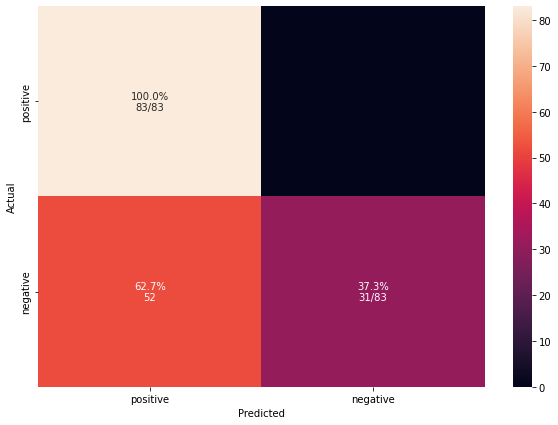

In [22]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, recall_score
matrix_index = ['positive', 'negative']

classpreds = gm.predict(test)
#classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(label, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)

recall = recall_score(y_testclass, classpreds, average ='macro')
print('UAR: ',recall)
#print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')
plt.savefig("Confusion_Matrix.jpg")